In [1]:
import pulp
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

# User input (normal case ~ 80 seconds for solving)
T = 16*3600 # s, maximal operation time for every machine 
MA = 10 # Real number of avaliable machines
t = {f"Test#{i}":5*60+100*i for i in range(200)} # s, time for solving task/test with index k

# (test case)
# T = 16 # s, maximal operation time for every machine 
# MA = 16 # Real number of avaliable machines
# t = {f"Test#{i}":2*(i+1) for i in range(8)} # s, time for solving task/test with index k

# System constants
M = math.ceil(sum(t.values())/T) # maximal number of machines (constant). It is not real number of machines. Value M is used to find feasible solution.
K = len(t)

# Print info / safety
print(f"Max time of test is {max(t.values())} s")
assert max(t.values())<=T, "Max allowed time for machine must be bigger than any test"

# Create a PuLP optimization problem
prob = pulp.LpProblem("TestPlanner", pulp.LpMinimize)

# Create a 2D/1D matrices of binary variables
s = [[pulp.LpVariable(f"s_m{m}_t{k}", cat=pulp.LpBinary) for k in range(K)] for m in range(M)]
u = [pulp.LpVariable(f"u_m{m}", cat=pulp.LpBinary) for m in range(M)]

# Create the constraint for each machine 1
for m in range(M):
    constraint_expr = pulp.lpSum(s[m][k] * t[f"Test#{k}"] for k in range(K)) <= T
    prob += constraint_expr, f"Machine_Time_Constraint_{m}"

# Create the constraint for each machine 2
for m in range(M):
    constraint_expr = pulp.lpSum(s[m][k] for k in range(K)) <= (K+1)*u[m]
    prob += constraint_expr, f"Machine_Utilization_Constraint_{m}"

# Create the constraint for each test
for k in range(K):
    constraint_expr = pulp.lpSum(s[m][k] for m in range(M)) == 1
    prob += constraint_expr, f"Force_Test_Constraint_{k}"

# Create objective function
prob += pulp.lpSum(u[m] for m in range(M))

print(f"M={M}; K={K}; total number of binary variables is {K*M}")

# Solve with default included solver
print("Solving ...")
status = prob.solve()
print("Solved")

# Print info
print(f"Solution status: {pulp.LpStatus[status]}({status})")


Max time of test is 20200 s
M=36; K=200; total number of binary variables is 7200
Solution status: Optimal(1)


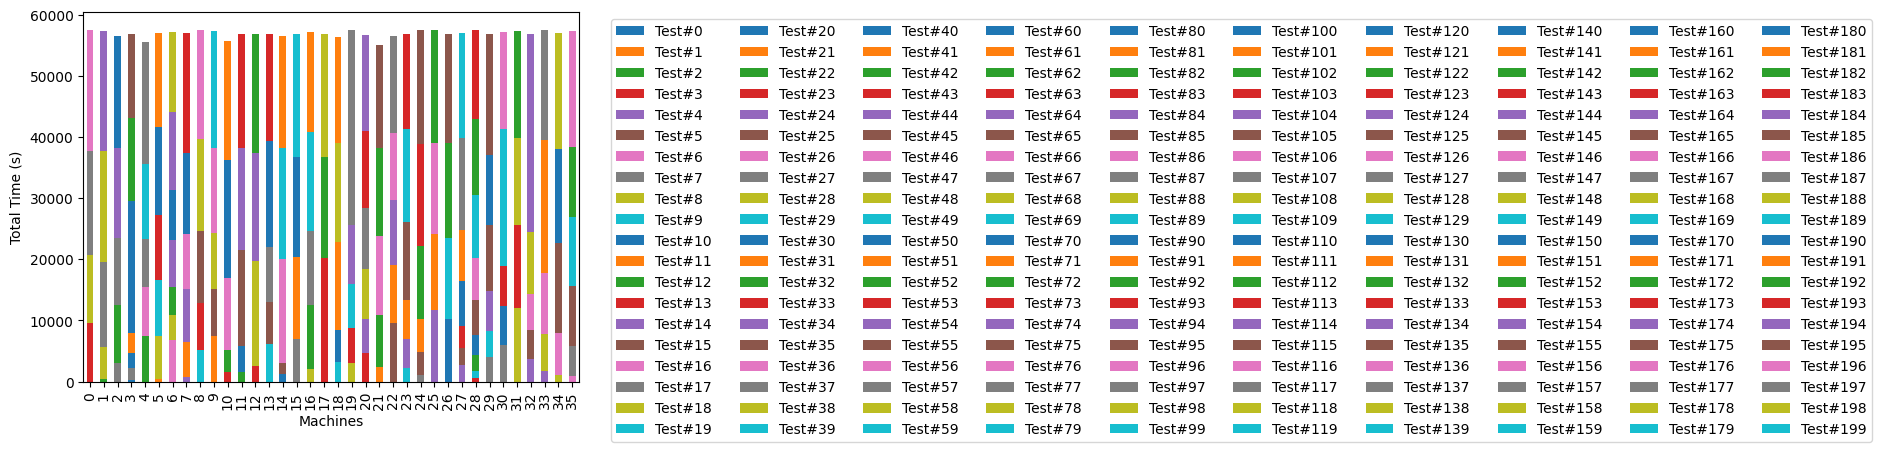

         Test#0  Test#1  Test#2  Test#3  Test#4  Test#5  Test#6  Test#7  \
Machine                                                                   
0           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1           0.0     0.0   500.0     0.0     0.0     0.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3         300.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           0.0   400.0     0.0     0.0     0.0     0.0     0.0     0.0   
6           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
7           0.0     0.0     0.0     0.0   700.0     0.0     0.0     0.0   
8           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
9           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
10          0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
11          0.0     0.0  

In [4]:
# Create an empty NumPy array with the same shape as your s matrix
solution_array = np.empty((M, K), dtype=float)
# Fill the NumPy array with the values of pulp variables
for m in range(M):
    for k in range(K):
        solution_array[m][k] = pulp.value(s[m][k])

# Perform element-wise multiplication
result = solution_array * np.array(list(t.values()))
# Convert to df
result_df = pd.DataFrame(result, columns=list(t.keys()))
result_df.index.name = "Machine"

# Plot stacked bar
result_df.plot(kind="bar", stacked=True)
plt.xlabel("Machines")
plt.ylabel("Total Time (s)")
plt.legend(ncol=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Print results in the view of table
print(result_df)